In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

In [ ]:
from google.colab import files
import pandas as pd

dataset = pd.read_csv("/content/drive/MyDrive/Kaggle.csv", index_col = 'Date')
dataset.index = pd.to_datetime(dataset.index)

In [ ]:
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900
...,...,...,...,...,...,...
2018-06-25,1143.599980,1143.910030,1112.780030,1124.810060,1124.810060,2157300
2018-06-26,1128.000000,1133.209960,1116.659060,1118.459960,1118.459960,1563200
2018-06-27,1121.339970,1131.836060,1103.620000,1103.979980,1103.979980,1293900


In [ ]:
df = dataset['Close']

In [ ]:
dataset = pd.DataFrame(df)
dataset

,Close
Date,
2013-01-02,359.288177
2013-01-03,359.496826
2013-01-04,366.600616
2013-01-07,365.001007
2013-01-08,364.280701
...,...
2018-06-25,1124.810060
2018-06-26,1118.459960
2018-06-27,1103.979980


In [ ]:
criteria = '2016-06-01'

train = dataset.loc[dataset.index < criteria, :]
test = dataset.loc[dataset.index >= criteria, :]
print('Train size: ', train.shape, 'Test size: ', test.shape)

Train size:  (859, 1) Test size:  (525, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
# 3차원으로 만든다
sequence = 60

X_train, y_train = [], []
for index in range(len(train_scaled) - sequence):
  X_train.append(train_scaled[index: index + sequence])
  y_train.append(train_scaled[index + sequence])

X_test, y_test = [], []
for index in range(len(test_scaled) - sequence):
  X_test.append(test_scaled[index: index+ sequence])
  y_test.append(train_scaled[index + sequence])

In [ ]:
# 데이터 형태 확인
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
print('X_train: ', X_train.shape, 'y_train: ', y_train.shape)
print('X_test: ', X_test.shape, 'y_test: ', y_test.shape)


X_train:  (799, 60, 1) y_train:  (799, 1)
X_test:  (465, 60, 1) y_test:  (465, 1)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 60, 128)           66560     
                                                                 
 dropout_24 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_25 (LSTM)              (None, 60, 256)           394240    
                                                                 
 dropout_25 (Dropout)        (None, 60, 256)           0         
                                                                 
 lstm_26 (LSTM)              (None, 60, 128)           197120    
                                                                 
 dropout_26 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_27 (LSTM)              (None, 64)               

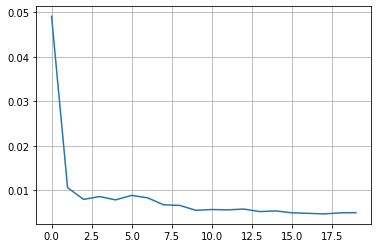

In [ ]:
# 모델링
model = Sequential() # RNN

model.add(LSTM(128,input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True, activation = 'relu'))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation = 'relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, y_train, batch_size = 16, epochs = 20, verbose = 1)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

In [ ]:
# 예측값
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

15/15 [==============================] - 2s 131ms/step


In [ ]:
y_train_pred[0][0][0]

0.1723368

In [ ]:
# y_train_pred = y_train_pred.reshape(-1,1)
# y_test_pred = y_test_pred.reshape(-1,1)
# y_train_pred

array([[0.1723368 ],
       [0.2463152 ],
       [0.27924526],
       ...,
       [0.92454976],
       [0.9231874 ],
       [0.92132777]], dtype=float32)

In [ ]:
len(X_test)

316

In [ ]:
y_train_pred[0]

array([0.1723368], dtype=float32)

15/15 [==============================] - 3s 142ms/step - loss: 4.1257e-15


,MAE,MSE,MAPE
Train,14.308589,382.126046,2.511318
Test,355.594624,128979.394298,70.211182


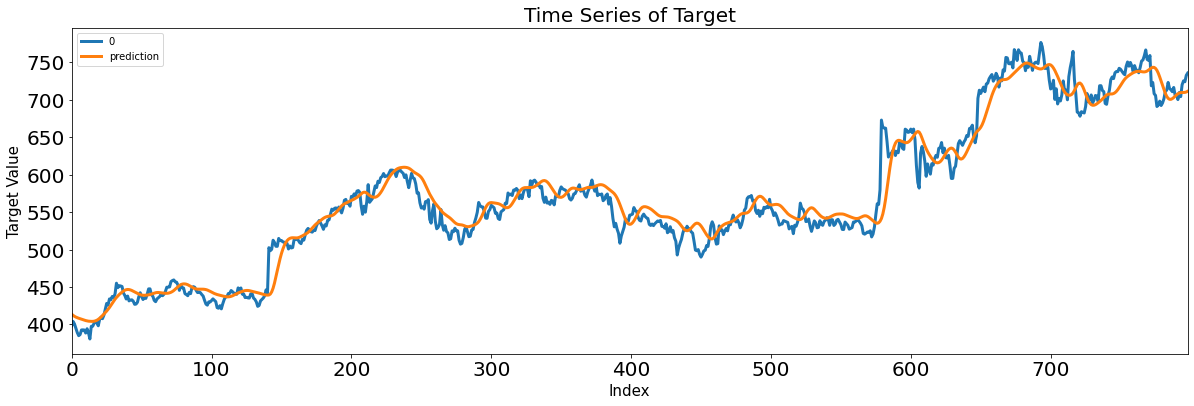

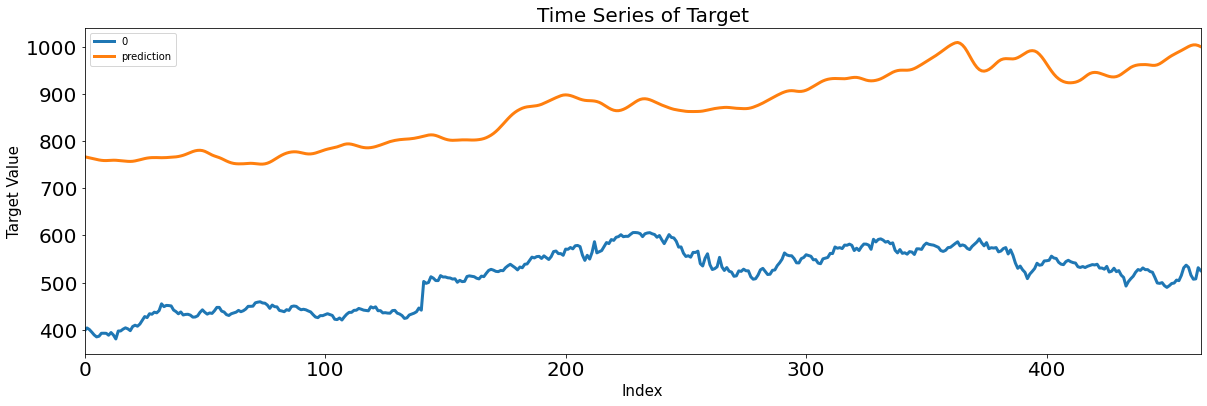

In [ ]:
# evaluation

result = model.evaluate(X_test, y_test_pred)
if scaler != []:
    y_train1 = scaler.inverse_transform(y_train)
    y_train_pred1 = scaler.inverse_transform(y_train_pred)
    y_test1 = scaler.inverse_transform(y_test)
    y_test_pred1 = scaler.inverse_transform(y_test_pred)


Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(y_train1), y_train_pred1.flatten(), 
                                                      pd.DataFrame(y_test1), y_test_pred1.flatten(), graph_on=True)
display(Score_LSTM)

In [ ]:
y_test_pred1

array([[ 829.53754],
       [ 828.4286 ],
       [ 827.2233 ],
       [ 826.06104],
       [ 825.0385 ],
       [ 824.2032 ],
       [ 823.5544 ],
       [ 823.0561 ],
       [ 822.663  ],
       [ 822.3271 ],
       [ 822.0132 ],
       [ 821.6949 ],
       [ 821.4156 ],
       [ 821.22577],
       [ 821.172  ],
       [ 821.2969 ],
       [ 821.629  ],
       [ 822.2554 ],
       [ 823.27893],
       [ 824.7584 ],
       [ 826.7086 ],
       [ 829.2246 ],
       [ 832.38556],
       [ 836.2206 ],
       [ 840.7306 ],
       [ 845.87036],
       [ 851.5167 ],
       [ 857.53076],
       [ 863.74316],
       [ 869.96204],
       [ 876.01306],
       [ 881.7538 ],
       [ 887.0956 ],
       [ 892.0079 ],
       [ 896.3765 ],
       [ 900.1527 ],
       [ 903.34125],
       [ 906.0131 ],
       [ 908.287  ],
       [ 910.3043 ],
       [ 912.2473 ],
       [ 914.26654],
       [ 916.4755 ],
       [ 918.8796 ],
       [ 921.4413 ],
       [ 924.1317 ],
       [ 926.94415],
       [ 929.